## Tugas Akhir Microcredential Associate Data Scientist

### ITS-05 kelompok 3

#### Preface

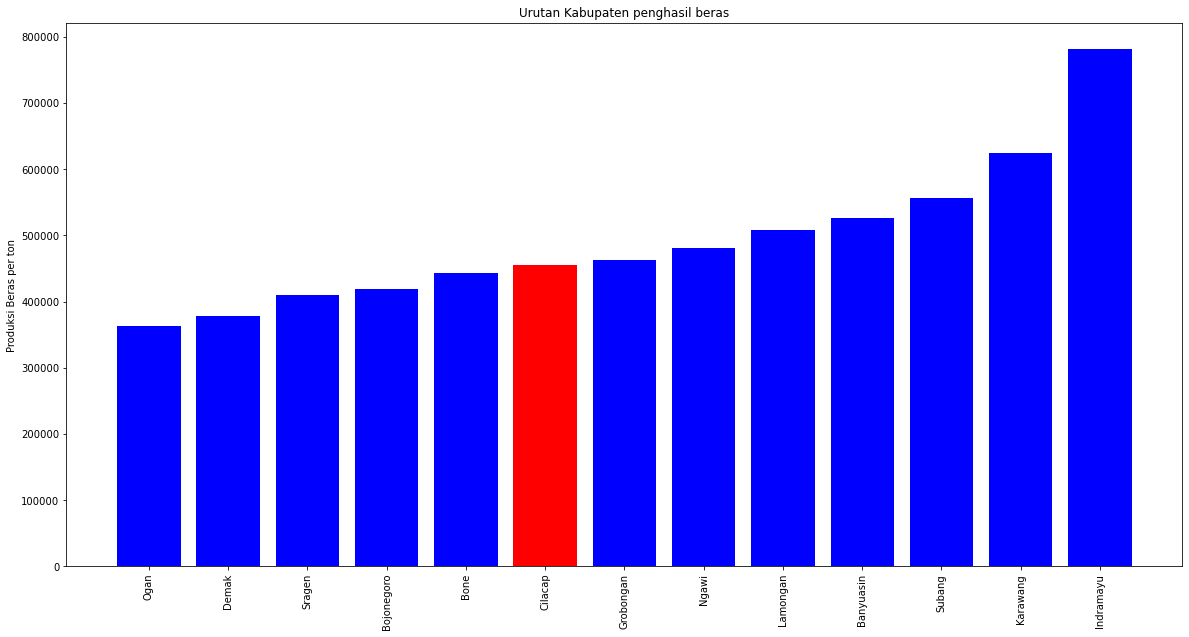

# 1. Import Necessary Library and Dataset

In [1]:
# Basic Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visulization
import missingno as mno
from sklearn.metrics import confusion_matrix

# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Deep Learning
from keras.layers import Dense, Activation
from keras.models import Sequential

In [2]:
# import 3 periode of season
# 2018-10 ~ 2019-03
# 2019-10 ~ 2020-03
# 2020-10 ~ 2021-03

ignore_data = ["8888"] # temporary, kalau ada ide buat ngolah nilai "8888", command ini bisa dihilangkan

df = pd.read_excel('dataset_iklim_cilacap_before_cleaning.xlsx', na_values = ignore_data)

# kalau emang perlu tambahan periode 2017-10 ~ 2018-03
# code dibawah bisa di un-comment
#df = pd.read_excel('dataset_iklim_cilacap_before_cleaning_plus_plus.xlsx', na_values = ignore_data) # versi 4 periode

In [3]:
# Quick data check

print(f"DataFrame shape : {df.shape}\n")
print(f"DataFrame columns: \n{df.columns}\n")
print(f"Columns type: {df.dtypes}")

df.head(3)

DataFrame shape : (547, 11)

DataFrame columns: 
Index(['Tanggal', 'Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ddd_x',
       'ff_avg', 'ddd_car'],
      dtype='object')

Columns type: Tanggal     object
Tn         float64
Tx         float64
Tavg       float64
RH_avg     float64
RR         float64
ss         float64
ff_x       float64
ddd_x      float64
ff_avg     float64
ddd_car     object
dtype: object


Tanggal    Tn    Tx  Tavg  RH_avg   RR   ss  ff_x  ddd_x  ff_avg ddd_car
0  01-10-2018  23.0  30.4  27.2    83.0  NaN  3.2   5.0  140.0     2.0      E 
1  02-10-2018  26.0   NaN  27.7    79.0  0.0  NaN   4.0  130.0     2.0      N 
2  03-10-2018  25.0  30.4  27.2    80.0  NaN  8.9   7.0  150.0     3.0      E

In [4]:
# Quick data prep

# kita ingin mengolah dataset ini di domain timeseries
from datetime import datetime
df['datetime'] = [datetime.strptime(x,'%d-%m-%Y') for x in df['Tanggal']] # change string 'Tanngal' to timeseries format

# change datetime as index; 
df = df.set_index('datetime')
df.drop('Tanggal', axis=1, inplace=True)

# change 'ddd_car' to categorical
df['ddd_car'] = pd.Categorical(df.ddd_car)

# renaming columns
df.rename(columns={"RR": "curah_hujan", "Tavg": "temp_avg", "RH_avg": "humid_avg", 
                   "ss": "sun_expo", "ff_x": "wind_max", "ff_avg": "wind_avg", "Tn": "temp_min", 
                   "Tx": "temp_max", "ddd_car": "wind_dir", "ddd_x": "wind_dir_max"}, inplace=True)



# Menambahkan kolom 'Year', 'Month', 'Weekday' untuk mempermudah visualisasi dan statiscical need
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday

# change to categorical
df['Year'] = pd.Categorical(df.Year)
df['Month'] = pd.Categorical(df.Month)

In [5]:
# Dividing 1 dataset to 3 periode (just for easier visualization & statistical description)
# 2018-10 ~ 2019-03
# 2019-10 ~ 2020-03
# 2020-10 ~ 2021-03

df_periode1 = df.loc['2018-10-01':'2019-03-01']
df_periode2 = df.loc['2019-10-01':'2020-03-01']
df_periode3 = df.loc['2020-10-01':'2021-03-01']

In [6]:
df_periode1.head(3)

temp_min  temp_max  temp_avg  humid_avg  curah_hujan  sun_expo  \
datetime                                                                     
2018-10-01      23.0      30.4      27.2       83.0          NaN       3.2   
2018-10-02      26.0       NaN      27.7       79.0          0.0       NaN   
2018-10-03      25.0      30.4      27.2       80.0          NaN       8.9   

            wind_max  wind_dir_max  wind_avg wind_dir  Year Month  Weekday  
datetime                                                                    
2018-10-01       5.0         140.0       2.0       E   2018    10        0  
2018-10-02       4.0         130.0       2.0       N   2018    10        1  
2018-10-03       7.0         150.0       3.0       E   2018    10        2

# 2. Exploratory Data Analysis

## 2.1 General Statistics

In [7]:
df.describe()

temp_min    temp_max    temp_avg   humid_avg  curah_hujan  \
count  460.000000  527.000000  542.000000  542.000000   375.000000   
mean    24.942391   31.384440   27.601292   83.167897    15.844000   
std      0.851992    1.295482    0.877727    3.816910    24.897926   
min     22.000000   25.900000   23.800000   70.000000     0.000000   
25%     24.400000   30.600000   27.100000   80.000000     1.000000   
50%     25.000000   31.600000   27.700000   83.000000     5.700000   
75%     25.400000   32.400000   28.200000   85.000000    22.750000   
max     27.000000   34.600000   29.700000   95.000000   199.500000   

         sun_expo    wind_max  wind_dir_max    wind_avg     Weekday  
count  520.000000  545.000000    545.000000  545.000000  547.000000  
mean     5.621346    4.157798    187.100917    1.451376    2.996344  
std      2.949587    1.350673     63.709177    0.728820    2.001827  
min      0.000000    1.000000     20.000000    0.000000    0.000000  
25%      3.200000    3.000000    140.000000    1.000000    1.000000  
50%      6.000000    4.000000    160.000000    1.000000    3.000000  
75%      8.000000    5.000000    230.000000    2.000000    5.000000  
max     11.000000   12.000000    360.000000    4.000000    6.000000

## 2.2 Plotting 'curah_hujan' per periode

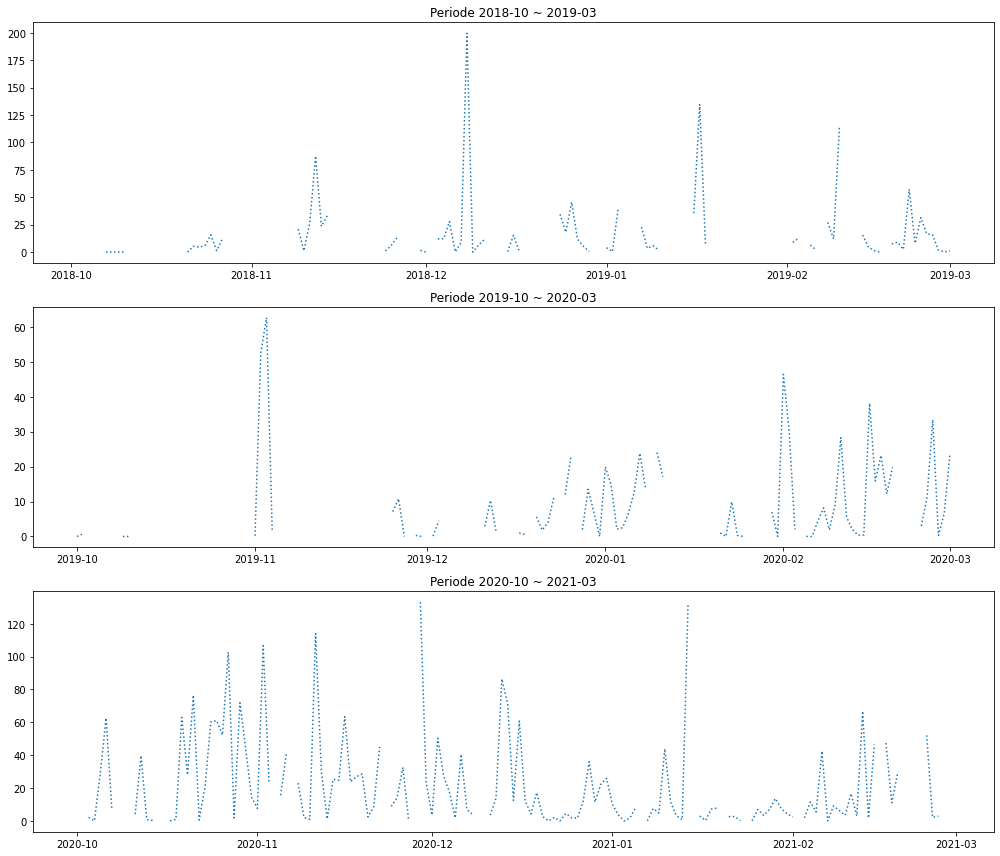

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14,12))

axes[0].plot(df_periode1['curah_hujan'], linestyle=':')
axes[0].set_title('Periode 2018-10 ~ 2019-03')

axes[1].plot(df_periode2['curah_hujan'], linestyle=':')
axes[1].set_title('Periode 2019-10 ~ 2020-03')

axes[2].plot(df_periode3['curah_hujan'], linestyle=':')
axes[2].set_title('Periode 2020-10 ~ 2021-03')

plt.tight_layout()

## 2.3 Boxplot 'curah_hujan' per periode

In [9]:
# Note : Urutan bulan boxplots dibawah dimulai dari yang terkecil ke terbesar. Keep that in mind when analyzing.
# Mau diubah ke 10-11-12-01-02-03 tapi masih belum bisa

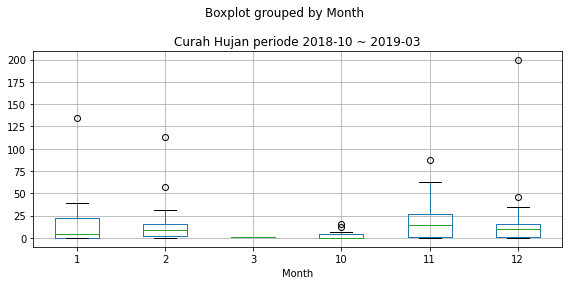

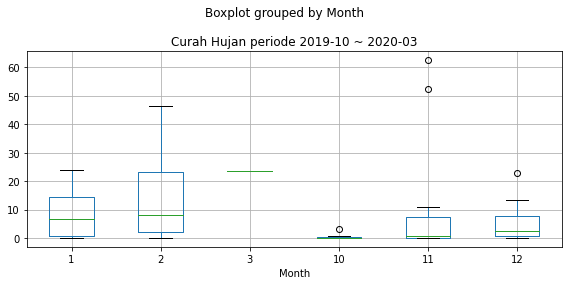

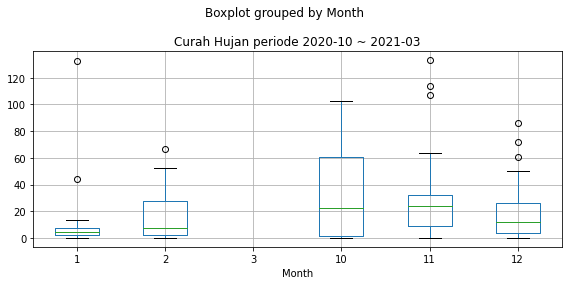

In [10]:
df_periode1.boxplot(column=['curah_hujan'], by='Month', figsize=(8, 4))
plt.title('Curah Hujan periode 2018-10 ~ 2019-03')
plt.tight_layout()

df_periode2.boxplot(column=['curah_hujan'], by='Month', figsize=(8, 4))
plt.title('Curah Hujan periode 2019-10 ~ 2020-03')
plt.tight_layout()

df_periode3.boxplot(column=['curah_hujan'], by='Month', figsize=(8, 4))
plt.title('Curah Hujan periode 2020-10 ~ 2021-03')
plt.tight_layout()


## 2.4 Pairplot all features vs 'curah_hujan'

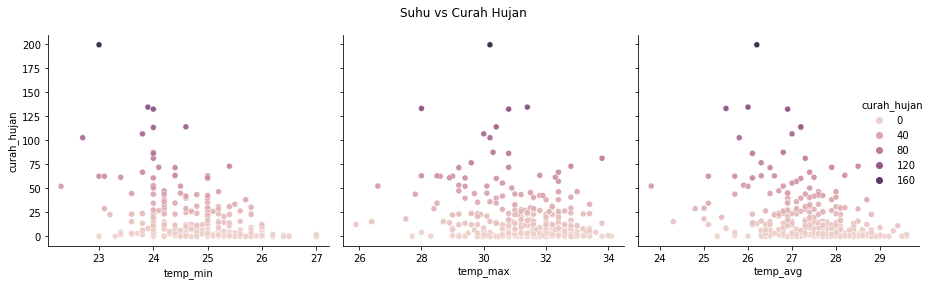

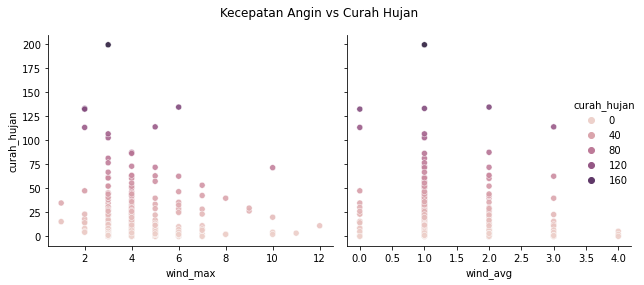

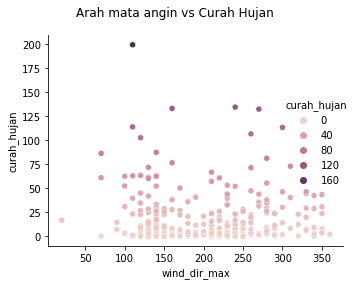

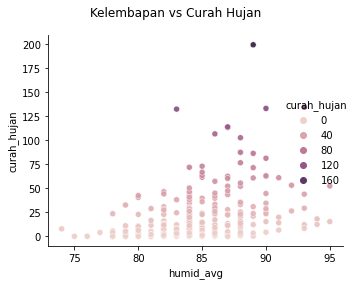

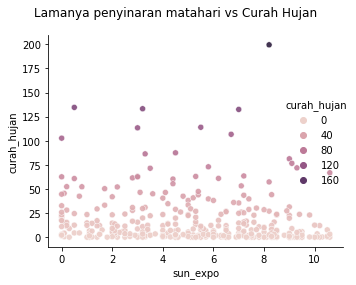

In [11]:
def pp(judul, *args):
    sns.pairplot(data=df, x_vars=args, y_vars=['curah_hujan'], height=4, aspect=1, kind='scatter', plot_kws={'alpha':0.9}, diag_kind = None, hue='curah_hujan')
    plt.suptitle(judul)
    plt.tight_layout()
    plt.show()
    
pp('Suhu vs Curah Hujan', 'temp_min', 'temp_max', 'temp_avg', )
pp('Kecepatan Angin vs Curah Hujan', 'wind_max', 'wind_avg')
pp('Arah mata angin vs Curah Hujan', 'wind_dir_max')
pp('Kelembapan vs Curah Hujan', 'humid_avg')
pp('Lamanya penyinaran matahari vs Curah Hujan', 'sun_expo')

## 2.5 Person Correlation Matrix

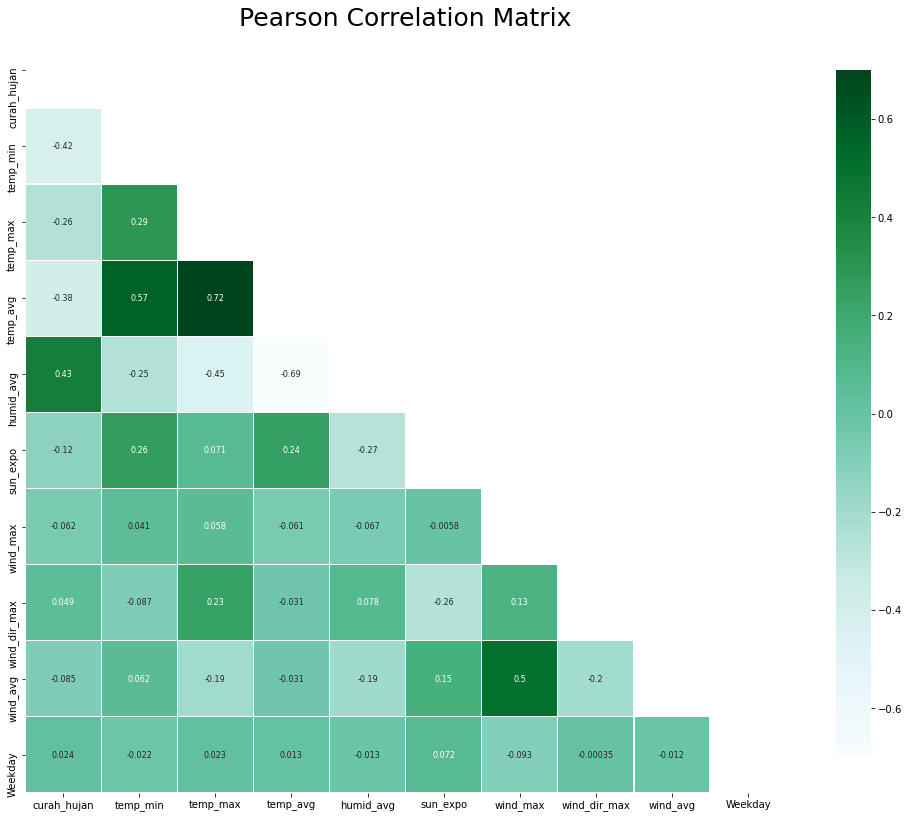

In [12]:
column_names = ['curah_hujan', 'temp_min', 'temp_max', 'temp_avg', 'humid_avg',
                'sun_expo', 'wind_max', 'wind_dir_max', 'wind_avg', 'wind_dir', 'Year',
                'Month', 'Weekday']



mask = np.zeros_like(df.reindex(columns=column_names).corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 14))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df.reindex(columns=column_names).corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

# sources, thx to : https://www.kaggle.com/burhanykiyakoglu/predicting-house-prices

## 2.6 3D Scatter plot

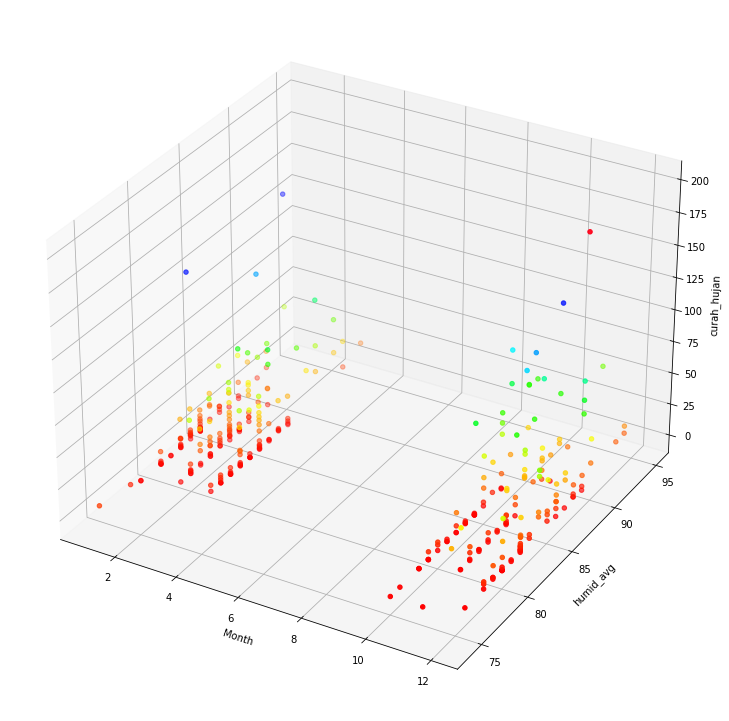

In [13]:
# Dari heatmap diatas kita ambil variabel dengan korelasi paling tinggi dengan curah_hujan yaitu humid_avg lalu kita buat scatter3D plotnya

fig = plt.figure(figsize=(13, 13))
ax = plt.axes(projection="3d")

z_points = df['curah_hujan']
x_points = df['Month']
y_points = df['humid_avg']
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

ax.set_xlabel('Month')
ax.set_ylabel('humid_avg')
ax.set_zlabel('curah_hujan')

plt.show()

## 2.7 Missing Data

<AxesSubplot:>

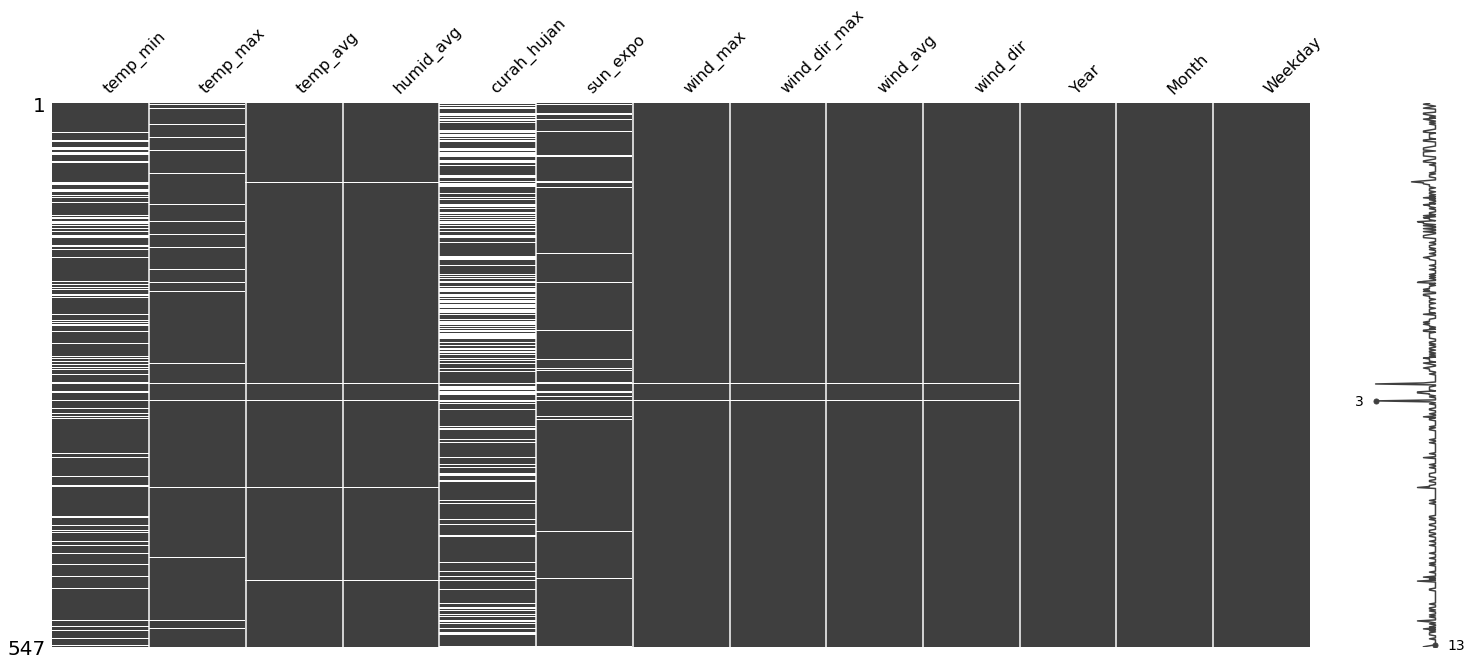

In [14]:
mno.matrix(df)

Di BMKG, tidak ada hujan sama sekali di interpretasi sebagai no-value. Dengan pengetahuan ini kita dapat mengubah missing_value di 'curah_hujan' menjadi value = 0

# 3. Data Preparation (data cleaning)

In [15]:
#missing data

df.isnull().sum()

temp_min         87
temp_max         20
temp_avg          5
humid_avg         5
curah_hujan     172
sun_expo         27
wind_max          2
wind_dir_max      2
wind_avg          2
wind_dir          2
Year              0
Month             0
Weekday           0
dtype: int64

In [16]:
# mengganti missing values di kolom curah_hujan dengan 0
df_filtered_1 = df.replace({'curah_hujan': np.nan},0)
df_filtered_1.head()

temp_min  temp_max  temp_avg  humid_avg  curah_hujan  sun_expo  \
datetime                                                                     
2018-10-01      23.0      30.4      27.2       83.0          0.0       3.2   
2018-10-02      26.0       NaN      27.7       79.0          0.0       NaN   
2018-10-03      25.0      30.4      27.2       80.0          0.0       8.9   
2018-10-04      23.0      29.9      27.1       75.0          0.0       8.1   
2018-10-05      22.0      29.8      25.4       82.0          0.0      10.2   

            wind_max  wind_dir_max  wind_avg wind_dir  Year Month  Weekday  
datetime                                                                    
2018-10-01       5.0         140.0       2.0       E   2018    10        0  
2018-10-02       4.0         130.0       2.0       N   2018    10        1  
2018-10-03       7.0         150.0       3.0       E   2018    10        2  
2018-10-04       4.0         140.0       2.0       SE  2018    10        3  
2018-10-05       4.0         140.0       2.0       SE  2018    10        4

In [17]:
# menghapus missing values perbaris di kolom curah hujan
df_filtered_2 = df.dropna(subset=['curah_hujan'])
df_filtered_2.head()

temp_min  temp_max  temp_avg  humid_avg  curah_hujan  sun_expo  \
datetime                                                                     
2018-10-02      26.0       NaN      27.7       79.0          0.0       NaN   
2018-10-04      23.0      29.9      27.1       75.0          0.0       8.1   
2018-10-07      25.0      31.7      26.9       84.0          0.0       9.5   
2018-10-08      25.0      29.4      26.4       87.0          0.0       9.4   
2018-10-09      25.0      29.8      27.2       82.0          0.0       9.2   

            wind_max  wind_dir_max  wind_avg wind_dir  Year Month  Weekday  
datetime                                                                    
2018-10-02       4.0         130.0       2.0       N   2018    10        1  
2018-10-04       4.0         140.0       2.0       SE  2018    10        3  
2018-10-07       6.0         110.0       3.0       E   2018    10        6  
2018-10-08       5.0         140.0       3.0       SE  2018    10        0  
2018-10-09       6.0         140.0       2.0       SE  2018    10        1

In [18]:
df_filtered_1.isnull().sum()

temp_min        87
temp_max        20
temp_avg         5
humid_avg        5
curah_hujan      0
sun_expo        27
wind_max         2
wind_dir_max     2
wind_avg         2
wind_dir         2
Year             0
Month            0
Weekday          0
dtype: int64

In [19]:
df_filtered_2.isnull().sum()

temp_min        46
temp_max         9
temp_avg         2
humid_avg        2
curah_hujan      0
sun_expo        12
wind_max         0
wind_dir_max     0
wind_avg         0
wind_dir         0
Year             0
Month            0
Weekday          0
dtype: int64

In [20]:
# Data check

print(f"original df shape :\t {df.shape}")
print(f"df_filtered_1 shape :\t {df_filtered_1.shape}")
print(f"df_filtered_2 shape :\t {df_filtered_2.shape}")

original df shape :	 (547, 13)
df_filtered_1 shape :	 (547, 13)
df_filtered_2 shape :	 (375, 13)


<AxesSubplot:>

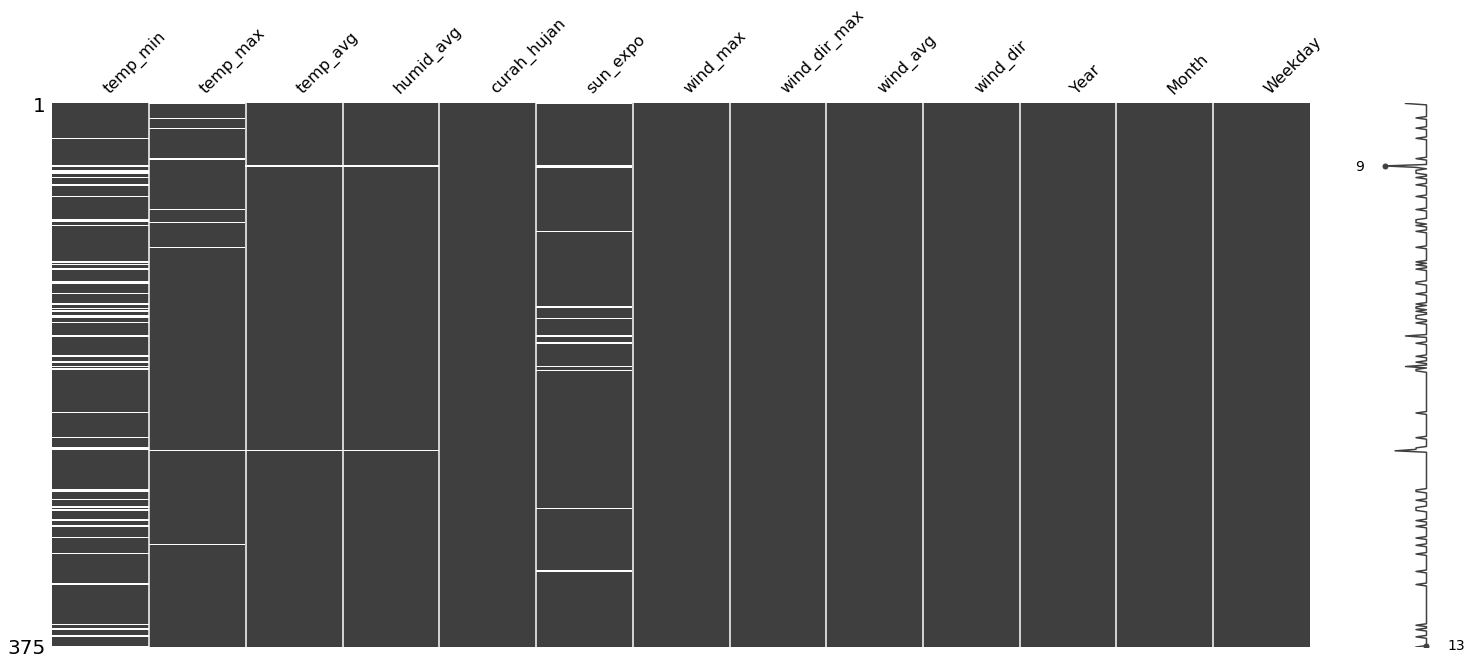

In [21]:
mno.matrix(df_filtered_2)

# 4. Before Modeling

In [22]:
# sementara drop all missing value
df_filtered_2 = df_filtered_2.dropna()
df_filtered_2.isnull().sum()

temp_min        0
temp_max        0
temp_avg        0
humid_avg       0
curah_hujan     0
sun_expo        0
wind_max        0
wind_dir_max    0
wind_avg        0
wind_dir        0
Year            0
Month           0
Weekday         0
dtype: int64

## 4.1 Splitting DataFrame into X and y

#### 4.1.1 splitting data into X and y with categorical data

In [23]:
# Disini kita menggunakan 5 fitur
X = df_filtered_2.drop(['curah_hujan', 'wind_dir_max', 'Weekday'], axis=1)
y = df_filtered_2.loc[:, 'curah_hujan']


# Karena banyak tools yang mewajibkan kita menggunakan numpy array, maka kita ubah X dan y menjadi array
X_array = X.to_numpy()
y_array = y.to_numpy()

# Karena feature scaling expect 2-d array, kita perlu mengubah y menjadi 2-d dulu
y_array = y_array.reshape(len(y), 1)

In [24]:
# Show first 2 rows
print(X_array[:2, :])
print(y_array[:2, :])

[[23.0 29.9 27.1 75.0 8.1 4.0 2.0 'SE' 2018 10]
 [25.0 31.7 26.9 84.0 9.5 6.0 3.0 'E ' 2018 10]]
[[0.]
 [0.]]


#### 4.1.2 splitting data into X and y without categorical data

## 4.2 OneHotEncoding (if using categorical)

In [25]:
# We want to encode 'wind_dir', 'Year', 'Month'
# Because those column is a pure Categorical, not ordinal data (like year 2019 is more blablabla than 2020)
# in order to avoid ordinal interpretation we use OneHotEncoder

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# encode wind_dir
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-3])], remainder='passthrough')
X_array = ct.fit_transform(X_array) # remember in order to train ml model, it needs to be a numpy array

In [27]:
# encode year

year_ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-2])], remainder='passthrough')
X_array = year_ct.fit_transform(X_array)

In [28]:
# encode month

month_ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-1])], remainder='passthrough')
X_array = month_ct.fit_transform(X_array)

In [29]:
# for fixing
# ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

X_array = np.asarray(X_array).astype('float32')

In [30]:
# Show first 1 rows
print(X_array[:1, :])
print(y_array[:1, :])

[[ 0.   0.   0.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
   0.   1.   0.   0.  23.  29.9 27.1 75.   8.1  4.   2. ]]
[[0.]]


## 4.3 Train-Test split

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, train_size = 0.8, random_state = 1)

## 4.4 Feature Scaling

#### 4.4.1 feature scaling dengan data categorical

Karena kita hanya ingin men-scale nilai numerical, kita transform dataset dengan indexing [:, 18:]

In [32]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler() # We cannot use same scaler for both X and y
X_train[:, 18:] = sc_X.fit_transform(X_train[:, 18:])
y_train = sc_y.fit_transform(y_train).ravel()

# We also need to transform test set
X_test[:, 18:] = sc_X.transform(X_test[:, 18:])
y_test = sc_y.transform(y_test)

# Kalau mau ngeluarin real-result, jangan lupa gunakan inverse_transform

In [33]:
X_train.shape

(249, 25)

#### 4.4.2 feature scaling tanpa data categorical

In [34]:
X_train.shape

(249, 25)

# 5. Modeling

## 5.1 Regresi Linear (Single Variable)

Untuk melakukan regresi linear, kita perlu mengetahui independent variable mana yang paling berpengaruh ke dependent variabel (curah_hujan)

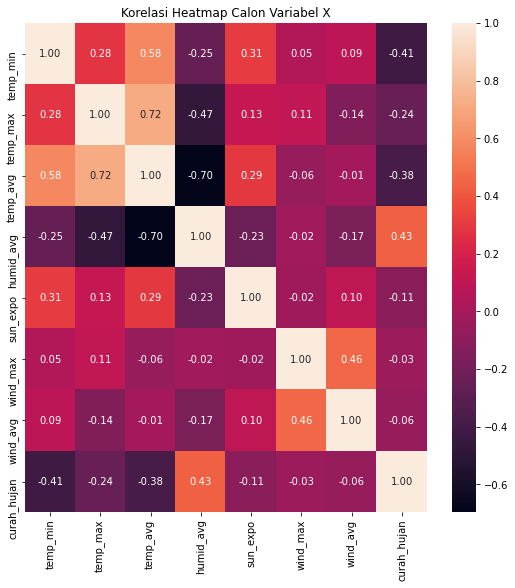

In [35]:
plt.figure(figsize=(9, 9))
sns.heatmap(pd.concat([X, y], axis=1).corr() ,annot=True ,fmt=".2f").set_title("Korelasi Heatmap Calon Variabel X")
plt.show()

Dari hasil visualisasi diatas, dapat diketahui humid_avg memiliki korelasi yang tinggi terhadap kolom curah_hujan / variabel dependent sehingga kita mengambil fitur/kolom humid_avg untuk di training

    Independent variabel(X) adalah humid_avg.
    Dependent variabel(y) adalah curah_hujan.



In [36]:
X_train[:1, :]

array([[ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        , -2.3434389 , -1.1449127 ,
        -0.49304566, -2.499579  ,  0.9525142 , -0.16529115,  0.79214954]],
      dtype=float32)

Jika kita perhatikan columns, berikut adalah urutannya:
'Month', 'Year', 'wind_dir', temp_min', 'temp_max', 'temp_avg', 'humid_avg', 'sun_expo', 'wind_max', 'wind_avg'

Oleh karena itu kita gunakan [:, -4]

In [37]:
# Kita ambil humid_avg saja dari train_test data, oleh karena itu kita menggunakan X_train[:, -4]

from sklearn import linear_model

linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train[:, -4].reshape(-1, 1), y_train)

y_pred = linear_reg.predict(X_test[:, -4].reshape(-1, 1))

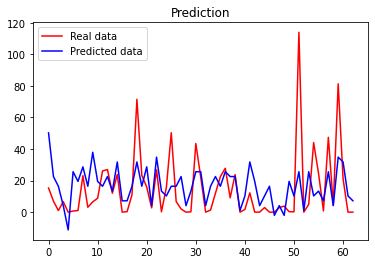

In [38]:
# Visual Evaluation
plt.plot(sc_y.inverse_transform(y_test), color = 'red', label = 'Real data')
plt.plot(sc_y.inverse_transform(y_pred), color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [39]:
# Model Evaluation

mse_linear_reg = mean_squared_error(y_test, y_pred)
mae_linear_reg = mean_absolute_error(y_test, y_pred)
r2_linear_reg = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_linear_reg})")
print(f"Mean Square Error: {mse_linear_reg}")
print(f"R2-score: {r2_linear_reg}")

Mean Absolute Error: 0.5225105448023498)
Mean Square Error: 0.5659730794625568
R2-score: 0.19014688122699797


## 5.2 Decision Tree

In [40]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor()
# Dengan menggunakan hasil train_test_split di Bab ke IV, kita langsung dapat menggunakan hasil splitting data tersebut
dt_reg.fit(X_train, y_train)
y_pred = dt_reg.predict(X_test)

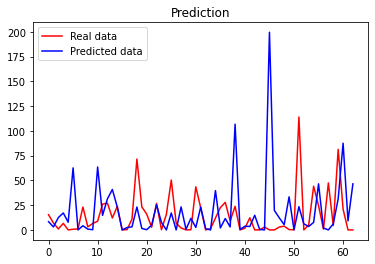

In [41]:
# Visual Evaluation
plt.plot(sc_y.inverse_transform(y_test), color = 'red', label = 'Real data')
plt.plot(sc_y.inverse_transform(y_pred), color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [42]:
# Model Evaluation

mse_dt_reg = mean_squared_error(y_test, y_pred)
mae_dt_reg = mean_absolute_error(y_test, y_pred)
r2_dt_reg = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_dt_reg}")
print(f"Mean Square Error: {mse_dt_reg}")
print(f"R2-score: {r2_dt_reg}")

Mean Absolute Error: 0.8038302559850785
Mean Square Error: 2.1047727362516278
R2-score: -2.011727636198525


## 5.3 Random Forest Regression

In [43]:
# Import Library Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

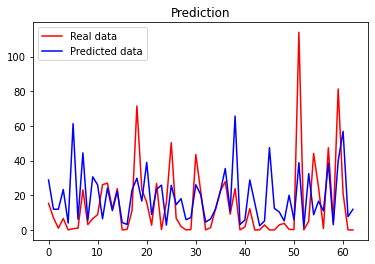

In [44]:
# Visual Evaluation
plt.plot(sc_y.inverse_transform(y_test), color = 'red', label = 'Real data')
plt.plot(sc_y.inverse_transform(y_pred), color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [45]:
# Model Evaluation

mse_rf_reg = mean_squared_error(y_test, y_pred)
mae_rf_reg = mean_absolute_error(y_test, y_pred)
r2_rf_reg = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_rf_reg}")
print(f"Mean Square Error: {mse_rf_reg}")
print(f"R2-score: {r2_rf_reg}")

Mean Absolute Error: 0.551273435444081
Mean Square Error: 0.6569982418113297
R2-score: 0.05989861626539661


## SVR

In [46]:
#import library SVR
from sklearn.svm import SVR

In [47]:
svr_lin = SVR(kernel='linear', C=1e3, gamma=0.1)
svr_poly = SVR(kernel='rbf', C=1e3)
svr_rbf = SVR(kernel='poly', C=1e3, degree=2)

svr_lin.fit(X_train[:, -4].reshape(-1, 1), y_train)
svr_rbf.fit(X_train[:, -4].reshape(-1, 1), y_train)
svr_poly.fit(X_train[:, -4].reshape(-1, 1), y_train)

y_lin = svr_lin.predict(X_test[:, -4].reshape(-1, 1))
y_rbf = svr_rbf.predict(X_test[:, -4].reshape(-1, 1))
y_poly = svr_poly.predict(X_test[:, -4].reshape(-1, 1))

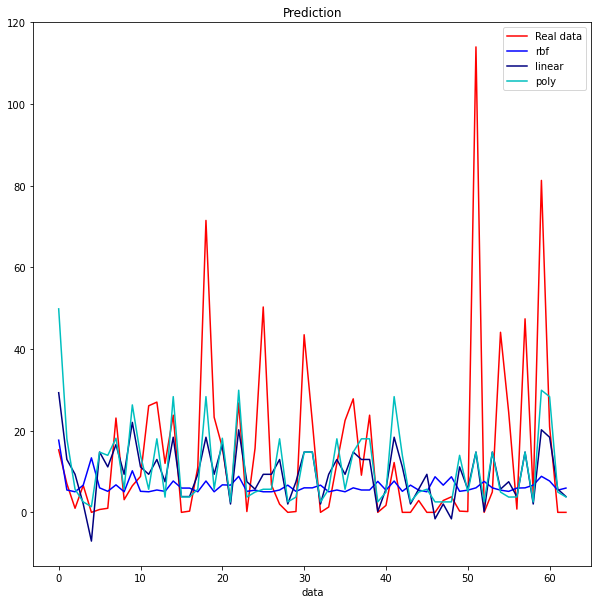

In [48]:
plt.figure(figsize=(10,10))
plt.plot(sc_y.inverse_transform(y_test), color = 'red', label = 'Real data')
plt.plot(sc_y.inverse_transform(y_rbf), color = 'blue', label = 'rbf')
plt.plot(sc_y.inverse_transform(y_lin), color = 'navy', label = 'linear')
plt.plot(sc_y.inverse_transform(y_poly), color = 'c', label = 'poly')
plt.title('Prediction')
plt.xlabel('data')
plt.legend()
plt.show()

In [49]:
# Model Evaluation

mse_svr_lin = mean_squared_error(y_test, y_lin)
mse_svr_poly = mean_squared_error(y_test, y_poly)
mse_svr_rbf = mean_squared_error(y_test, y_rbf)
mae_svr_lin = mean_absolute_error(y_test, y_lin)
mae_svr_poly = mean_absolute_error(y_test, y_poly)
mae_svr_rbf = mean_absolute_error(y_test, y_rbf)
r2_svr_lin = r2_score(y_test, y_lin)
r2_svr_poly = r2_score(y_test, y_poly)
r2_svr_rbf = r2_score(y_test, y_rbf)

print('SVR LINEAR')
print(f"Mean Absolute Error: {mae_svr_lin}")
print(f"Mean Square Error: {mse_svr_lin}")
print(f"R2-score: {r2_svr_lin}")
print('SVR POLYNOMIAL')
print(f"Mean Absolute Error: {mae_svr_poly}")
print(f"Mean Square Error: {mse_svr_poly}")
print(f"R2-score: {r2_svr_poly}")
print('SVR RBF')
print(f"Mean Absolute Error: {mae_svr_rbf}")
print(f"Mean Square Error: {mse_svr_rbf}")
print(f"R2-score: {r2_svr_rbf}")

SVR LINEAR
Mean Absolute Error: 0.4492017618818567
Mean Square Error: 0.6075273657176334
R2-score: 0.13068668860791377
SVR POLYNOMIAL
Mean Absolute Error: 0.4694808512431722
Mean Square Error: 0.6143169630300809
R2-score: 0.12097142694932073
SVR RBF
Mean Absolute Error: 0.5239228367969093
Mean Square Error: 0.8001631340398633
R2-score: -0.14495659448098142


## 5.3 ANN

Karena contoh yang digunakan di module merupakan contoh ANN classification, saya gunakan referensi dari luar

source : https://stackoverflow.com/questions/49008074/how-to-create-a-neural-network-for-regression

In [50]:
print(X_train[:1])
print(X_train.shape)

[[ 0.          0.          0.          1.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
  -2.3434389  -1.1449127  -0.49304566 -2.499579    0.9525142  -0.16529115
   0.79214954]]
(249, 25)


In [51]:
print(f"input dim = {X_train.shape[1:]}")

input dim = (25,)


In [52]:
# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim = 25))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size = 10, epochs = 100)

y_pred = model.predict(X_test)



Epoch 1/100
25/25 [==============================] - 1s 3ms/step - loss: 1.0224
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 0.8865
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7920
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7228
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6640
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6265
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 0.5739
Epoch 8/100
25/25 [==============================] - 0s 4ms/step - loss: 0.5260
Epoch 9/100
25/25 [==============================] - 0s 4ms/step - loss: 0.4933
Epoch 10/100
25/25 [==============================] - 0s 4ms/step - loss: 0.4401
Epoch 11/100
25/25 [==============================] - 0s 4ms/step - loss: 0.4067
Epoch 12/100
25/25 [==============================] - 0s 3ms/step - loss: 0.3736
Epoch 13/100
25/25 [=================

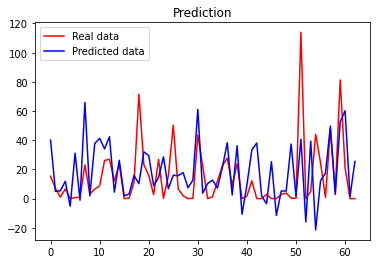

In [53]:
# Visual Evaluation
plt.plot(sc_y.inverse_transform(y_test), color = 'red', label = 'Real data')
plt.plot(sc_y.inverse_transform(y_pred), color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [54]:
# Model Evaluation

mse_ann_reg = mean_squared_error(y_test, y_pred)
mae_ann_reg = mean_absolute_error(y_test, y_pred)
r2_ann_reg = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae_ann_reg}")
print(f"Mean Square Error: {mse_ann_reg}")
print(f"R2-score: {r2_ann_reg}")

Mean Absolute Error: 0.6312320661839832
Mean Square Error: 0.7930699042849811
R2-score: -0.13480686395913466


## RNN

## 6. Model evaluation and hyperparameter tuning

## 6.1 Mean Absolute Error

In [55]:
models = pd.DataFrame({'Model': ['Linear Regression', 'Decision Tree', 'Random Forest Regression', 'ANN'],
                       'Score': [mae_linear_reg, mae_dt_reg, mae_rf_reg, mae_ann_reg]})

models.sort_values(by = 'Score', ascending = True, ignore_index = True)


Model     Score
0         Linear Regression  0.522511
1  Random Forest Regression  0.551273
2                       ANN  0.631232
3             Decision Tree  0.803830

Note : Lower MAE are better.

## 6.2 R2

In [56]:
models = pd.DataFrame({'Model': ['Linear Regression', 'Decision Tree', 'Random Forest Regression', 'ANN'],
                       'Score': [r2_linear_reg, r2_dt_reg, r2_rf_reg, r2_ann_reg]})

models.sort_values(by = 'Score', ascending = False, ignore_index = True)


Model     Score
0         Linear Regression  0.190147
1  Random Forest Regression  0.059899
2                       ANN -0.134807
3             Decision Tree -2.011728

Note : Higher R2 score are better.

## 6.2 K-fold cross validation

It is important to not get too carried away with models with impressive training accuracy as what we should focus on instead is the model's ability to predict out-of-samples data, in other words, data our model has not seen before.

This is where k-fold cross validation comes in. K-fold cross validation is a technique whereby a subset of our training set is kept aside and will act as holdout set for testing purposes. Here is a great [video](https://www.youtube.com/watch?v=fSytzGwwBVw) explaining the concept in more detail. 

In [57]:
# Create a list which contains regressors

regressors = []

regressors.append(DecisionTreeRegressor())
regressors.append(RandomForestRegressor())


len(regressors)

2

In [58]:
# Create a list which contains cross validation results for each classifier

cv_results = []
for regressor in regressors:
    cv_results.append(cross_val_score(regressor, X_train, y_train, scoring = 'r2', cv = 10))

In [59]:
# Mean and standard deviation of cross validation results for each classifier  

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [60]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std, 'Algorithm': ['Decision Tree', 'Random Forest Regression']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

Cross Validation Mean  Cross Validation Std                 Algorithm
0               0.021372              0.430948  Random Forest Regression
1              -1.055121              1.429593             Decision Tree

C:\Users\K\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Cross Validation Scores')

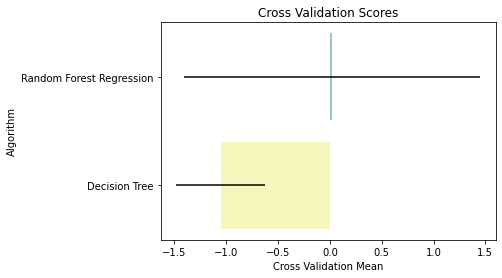

In [61]:
sns.barplot('Cross Validation Mean', 'Algorithm', data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Algorithm'], palette = 'Set3', **{'xerr': cv_std})
plt.ylabel('Algorithm')
plt.title('Cross Validation Scores')